<a href="https://colab.research.google.com/github/fidelis2025/stankelly-website/blob/main/Acen_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pip setuptools wheel
!pip install pandas numpy scipy statsmodels scikit-learn factor_analyzer semopy openpyxl pingouin

  Using cached factor_analyzer-0.5.1.tar.gz (42 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached semopy-2.3.11.tar.gz (1.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=302fc78e21a994f933edb8dbf89363f64be100349c6c3600ed063f458afe8a49
  Stored in directory: /root/.cache/pip/wheels/a2/af/06/f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659769 sha256=1e9337d5a9824431e49afa86cd76ad0219744d2613b6c802a7385ce86bccf3b5
  Stored in directory: /root/.cache/pip/wheels/c6/24/8b/be911b059a61f490f38425eb19bf2fed470a5ead97228e8255
Successfully built factor_analyzer semopy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [pin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 1: Upload file manually
from google.colab import files
import pandas as pd

uploaded = files.upload()  # This lets you pick file from your PC
file_path = list(uploaded.keys())[0]  # Automatically use uploaded filename

# Step 2: Read dataset
# Use pd.read_excel for .xlsx files
data = pd.read_excel(file_path)

Saving Acen_Dataset.xlsx to Acen_Dataset.xlsx


Data Cleaning and Screening

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.spatial.distance import mahalanobis
from semopy import Model, Optimizer
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

# Load Excel file
data = pd.read_excel("Acen_Dataset.xlsx")

# Check missing values
print(data.isnull().sum())

# Mean substitution for minor missing values
data = data.fillna(data.mean())

z_scores = np.abs(stats.zscore(data.select_dtypes(include=[np.number])))
outliers = np.where(z_scores > 3)
print("Univariate outliers:", outliers)

X = data.select_dtypes(include=[np.number])
cov_matrix = np.cov(X.values, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mean_vals = X.mean().values

md = []
for i in range(len(X)):
    md.append(mahalanobis(X.iloc[i], mean_vals, inv_cov_matrix))

data["Mahalanobis_D"] = md

# Critical chi square value
from scipy.stats import chi2
threshold = chi2.ppf((1-0.001), df=X.shape[1])
print("Mahalanobis threshold:", threshold)

Sex                        0
Education                  0
Profession                 0
Experience                 0
Age                        0
Control_Environment        0
Risk_Assessment            0
Control_Activities         0
Communication              0
Monitoring                 0
Internal_Control_System    0
CASH_Management            0
Budget_Performance         0
Accountability             0
Reporting                  0
Public_Financial_Mgt       0
Political_Influence        0
dtype: int64
Univariate outliers: (array([ 98, 108, 111, 153, 172, 179]), array([11, 16, 16, 11, 16, 12]))
Mahalanobis threshold: 40.79021670690253


Diagnostic Tests

In [ ]:
# Normality
for col in data.columns:
    print(col, stats.skew(data[col]), stats.kurtosis(data[col]))

# Multicollinearity using VIF
X = data[["Control_Environment","Risk_Assessment","Control_Activities","Communication","Monitoring","Political_Influence"]]

X_const = sm.add_constant(X)

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i)
              for i in range(X.shape[1])]

print(vif)

Sex 0.9460766582498692 -1.1049389567147603
Education 0.18329030295351978 -0.5032873772634465
Profession -0.9070981341960085 -0.6726842575441272
Experience -0.1098218507860244 -1.007913223820078
Age -0.05736465568748709 -0.3638530034144818
Control_Environment -0.2568804070100125 -0.44348988484454743
Risk_Assessment 0.17584510299746922 -0.18848964558430348
Control_Activities 0.03339684775650246 -0.3770597958542581
Communication 0.3324675086179434 -0.1306475614799978
Monitoring 0.12703508273889794 0.08831782385067166
Internal_Control_System -0.012587410270806239 -0.5895796314254844
CASH_Management 0.3142188787231715 -0.0018744036704965161
Budget_Performance 0.07517880877163508 -0.2596715591755028
Accountability 0.14705281720529928 -0.060241818019080906
Reporting -0.227780715964412 -0.07280252670966547
Public_Financial_Mgt -0.04767192233919976 -0.49310285944321386
Political_Influence 0.024913144682952883 1.5361387914802593
Mahalanobis_D 3.9968885186851177 25.320108228342136
              V

Descriptive Statistics

In [ ]:
desc = data.describe()
print(desc[["Control_Environment","Risk_Assessment",
            "Control_Activities","Communication",
            "Political_Influence",
            "Public_Financial_Mgt"]])

       Control_Environment  Risk_Assessment  Control_Activities  \
count           297.000000       297.000000          297.000000   
mean              2.240037         2.349944            2.135904   
std               0.476031         0.567713            0.536168   
min               1.000000         1.000000            1.000000   
25%               1.909091         2.000000            1.818182   
50%               2.272727         2.333333            2.181818   
75%               2.545455         2.833333            2.545455   
max               3.300000         4.000000            3.636364   

       Communication  Political_Influence  Public_Financial_Mgt  
count     297.000000           297.000000            297.000000  
mean        2.124158             3.660943              2.282523  
std         0.514465             0.459028              0.475766  
min         1.000000             2.200000              1.076923  
25%         1.750000             3.500000              1.923077  


Correlation Analysis

                      Control_Environment  Risk_Assessment  \
Control_Environment              1.000000         0.406196   
Risk_Assessment                  0.406196         1.000000   
Control_Activities               0.654140         0.445998   
Communication                    0.609244         0.370917   
Monitoring                       0.558130         0.459029   
Political_Influence             -0.059376         0.057840   
Public_Financial_Mgt             0.585374         0.426612   

                      Control_Activities  Communication  Monitoring  \
Control_Environment             0.654140       0.609244    0.558130   
Risk_Assessment                 0.445998       0.370917    0.459029   
Control_Activities              1.000000       0.725948    0.702240   
Communication                   0.725948       1.000000    0.648195   
Monitoring                      0.702240       0.648195    1.000000   
Political_Influence            -0.025114      -0.071609   -0.004383   
Public

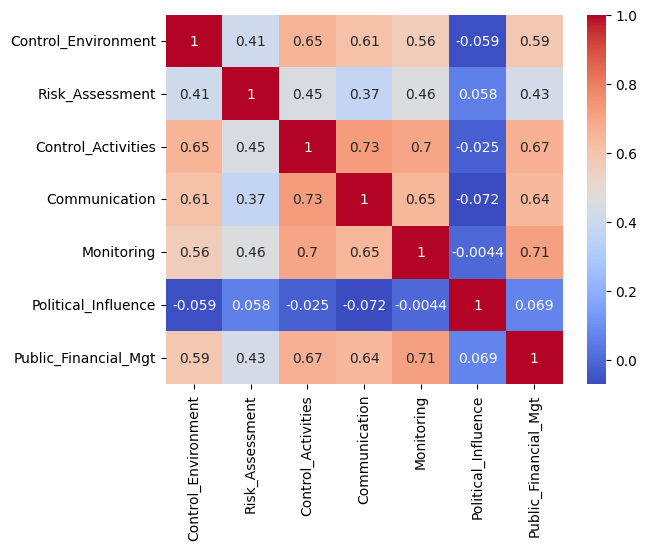

In [ ]:
corr = data[["Control_Environment","Risk_Assessment",
             "Control_Activities","Communication","Monitoring",
             "Political_Influence",
             "Public_Financial_Mgt"]].corr()

print(corr)

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

Moderation Test for H05 (Create interaction term)

In [ ]:
data["ICS"] = data["Internal_Control_System"]
data["Interaction"] = data["ICS"] * data["Political_Influence"]

model5 = smf.ols("Public_Financial_Mgt ~ ICS + Political_Influence + Interaction", data=data).fit()
print(model5.summary())

                             OLS Regression Results                             
Dep. Variable:     Public_Financial_Mgt   R-squared:                       0.582
Model:                              OLS   Adj. R-squared:                  0.578
Method:                   Least Squares   F-statistic:                     136.0
Date:                  Thu, 26 Feb 2026   Prob (F-statistic):           3.23e-55
Time:                          04:20:41   Log-Likelihood:                -70.740
No. Observations:                   297   AIC:                             149.5
Df Residuals:                       293   BIC:                             164.3
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept     

Exploratory Factor Analysis

In [ ]:
efa_vars = data[["Control_Environment","Risk_Assessment",
                 "Control_Activities","Communication",
                 "Monitoring",
                 "CASH_Management","Budget_Performance",
                 "Accountability","Reporting"]]

kmo_all, kmo_model = calculate_kmo(efa_vars)
print("KMO:", kmo_model)

chi_square_value, p_value = calculate_bartlett_sphericity(efa_vars)
print("Bartlett test p value:", p_value)

fa = FactorAnalyzer(n_factors=3, rotation="varimax")
fa.fit(efa_vars)

loadings = pd.DataFrame(fa.loadings_,
                        index=efa_vars.columns)
print(loadings)

KMO: 0.918829960301972
Bartlett test p value: 6.343808398346671e-294
                            0         1         2
Control_Environment  0.609495  0.344930  0.199525
Risk_Assessment      0.229315  0.204816  0.949569
Control_Activities   0.802879  0.335283  0.206672
Communication        0.738996  0.348505  0.138858
Monitoring           0.591125  0.506382  0.229182
CASH_Management      0.277969  0.671150  0.214199
Budget_Performance   0.526008  0.561229  0.097840
Accountability       0.312729  0.639748  0.163615
Reporting            0.392511  0.737640  0.098346


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Structural Equation Modeling (Measurement and Structural Model)

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.spatial.distance import mahalanobis
from semopy import Model, Optimizer
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

model_desc = """
# Measurement model
Internal_Control_System =~ Control_Environment + Risk_Assessment + Control_Activities + Communication + Monitoring
Public_Financial_Mgt =~ CASH_Management + Budget_Performance + Accountability + Reporting

# Structural model
Public_Financial_Mgt ~ Internal_Control_System + Political_Influence
"""

from semopy import Model, Optimizer, calc_stats

# Define the model
sem_model = Model(model_desc)

# Fit the model
sem_model.fit(data)

# Inspect parameter estimates
print(sem_model.inspect())

# Calculate model fit statistics
stats = calc_stats(sem_model)
print("Model Fit:")
print(stats)

                       lval  op                     rval  Estimate  Std. Err  \
0      Public_Financial_Mgt   ~  Internal_Control_System  0.978648  0.087601   
1      Public_Financial_Mgt   ~      Political_Influence  0.088193  0.034493   
2       Control_Environment   ~  Internal_Control_System  1.000000         -   
3           Risk_Assessment   ~  Internal_Control_System  0.838572  0.096997   
4        Control_Activities   ~  Internal_Control_System  1.323924  0.089686   
5             Communication   ~  Internal_Control_System  1.191453  0.086157   
6                Monitoring   ~  Internal_Control_System  1.360500  0.097125   
7           CASH_Management   ~     Public_Financial_Mgt  1.000000         -   
8        Budget_Performance   ~     Public_Financial_Mgt  1.137945  0.088127   
9            Accountability   ~     Public_Financial_Mgt  1.129135  0.094161   
10                Reporting   ~     Public_Financial_Mgt  1.226844  0.091413   
11  Internal_Control_System  ~~  Interna

SEM Moderation Model

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.spatial.distance import mahalanobis
from semopy import Model, Optimizer
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from semopy import Model, Optimizer, calc_stats  # you already imported this

# Create observed interaction
data['Interaction'] = data['Internal_Control_System'] * data['Political_Influence']

# Define SEM model
model_mod = """
Internal_Control_System =~ Control_Environment + Risk_Assessment + Control_Activities + Communication + Monitoring
Public_Financial_Mgt =~ CASH_Management + Budget_Performance + Accountability + Reporting

Public_Financial_Mgt ~ Internal_Control_System + Political_Influence + Interaction
"""

# Load data into Model
sem_mod_model = Model(model_mod)
sem_mod_model.load_dataset(data)

# Fit the model directly (this will store last_result)
sem_mod_model.fit()  # <-- important, ensures model is "fit"

# Inspect parameter estimates
print(sem_mod_model.inspect())

# Calculate fit statistics
stats_results = calc_stats(sem_mod_model)
print(stats_results)

                       lval  op                     rval  Estimate  Std. Err  \
0      Public_Financial_Mgt   ~  Internal_Control_System  0.596648  0.070227   
1      Public_Financial_Mgt   ~      Political_Influence -0.093724  0.040853   
2      Public_Financial_Mgt   ~              Interaction  0.080334  0.011259   
3       Control_Environment   ~  Internal_Control_System  1.000000         -   
4           Risk_Assessment   ~  Internal_Control_System  0.833873  0.098154   
5        Control_Activities   ~  Internal_Control_System  1.342197  0.091783   
6             Communication   ~  Internal_Control_System  1.200799  0.087705   
7                Monitoring   ~  Internal_Control_System  1.348283  0.098923   
8           CASH_Management   ~     Public_Financial_Mgt  1.000000         -   
9        Budget_Performance   ~     Public_Financial_Mgt  1.130038  0.112037   
10           Accountability   ~     Public_Financial_Mgt  1.131414  0.119371   
11                Reporting   ~     Publ

Harman Single Factor Test for Common Method Bias

In [ ]:
fa_harman = FactorAnalyzer(n_factors=1, rotation=None)
fa_harman.fit(efa_vars)

variance = fa_harman.get_factor_variance()
print("Variance explained by single factor:", variance)

Variance explained by single factor: (array([4.8567942]), array([0.5396438]), array([0.5396438]))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
